<a href="https://colab.research.google.com/github/vigneshramesh1/group32-capstone/blob/joseph_svm/Models/Ensemble_SVM_RFC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [3]:
PATH = '/content/drive/MyDrive/SER 517/Dataset/'
dataset = pd.read_csv(PATH + 'csv_preprocessed.csv')

In [10]:
# Creating dataset using columns only from Mutual Information

data = dataset[["SrcWin", "DstWin", "dHops", "dTtl", "TotBytes", "SrcBytes", "sMeanPktSz", "DstGap", "SrcGap", "dTos", "DstTCPBase", "SrcTCPBase", "TcpRtt", "Proto_udp", "DstBytes", "AckDat" , "dMeanPktSz", "Proto_tcp", "SynAck", "Load"]]

In [11]:
def concat_column(data, column_name):
  concat_column_data = pd.concat([data, dataset[column_name]], axis = 1)
  return concat_column_data

data = concat_column(data, "Attack Type")

In [12]:
# Separate features and target
X = data.loc[:, data.columns != 'Attack Type']  # All columns except 'Attack Type'
y = data['Attack Type']  # Only the 'Attack Type' column

In [13]:
print("X size:", X.shape)
print("y size:", y.shape)

X size: (1215675, 20)
y size: (1215675,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [15]:
def pca_train_test(X_train, X_test, no_of_components):
  from sklearn.decomposition import PCA

  # Initialize PCA model
  pca = PCA(n_components=no_of_components)

  # Fit and transform the training data
  Principal_components_train = pca.fit_transform(X_train)
  column_names = ["PC " + str(i) for i in range(1, no_of_components + 1)]

  # Create a DataFrame for the training data
  train_data = pd.DataFrame(data=Principal_components_train, columns=column_names)

  # # Transform the test data using the same PCA model
  # Principal_components_test = pca.transform(X_test)

  # # Create a DataFrame for the test data
  # test_data = pd.DataFrame(data=Principal_components_test, columns=column_names)

  test_data = pca.transform(X_test)

  return train_data, test_data

In [16]:
X_train, X_test = pca_train_test(X_train, X_test, 15)

In [17]:
# Initialize and train the SVC model
svc_model = SVC(kernel='rbf', random_state=42)  # You can choose different kernels like 'rbf', 'poly', etc.
svc_model.fit(X_train, y_train)

SVC(random_state=42)

In [18]:
# Predictions
y_pred_SVC = svc_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [ ]:
# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred_SVC)
# print(f'Accuracy of SVC: {accuracy}')

In [19]:
# Initialize and train the RandomForestClassifier model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 5, criterion = "entropy", random_state =21)

In [20]:
rfc.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=5, random_state=21)

In [21]:
y_pred_RFC = rfc.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred_RFC)
# print(f'Accuracy of SVC: {accuracy}')

In [22]:
from sklearn.ensemble import VotingClassifier

# Create the Voting Classifier with both SVM and Random Forest
voting_clf = VotingClassifier(
    estimators=[('svm', svc_model), ('rf', rfc)],
    voting='hard'
)

In [23]:
# Train the ensemble model
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('svm', SVC(random_state=42)),
                             ('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     n_estimators=5,
                                                     random_state=21))])

In [24]:
# Predict and evaluate the ensemble model
y_pred_ensemble = voting_clf.predict(X_test)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print(f'Ensemble (Voting) Accuracy: {accuracy_ensemble}')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Ensemble (Voting) Accuracy: 0.9893063964201105


In [ ]:
# Compute and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_ensemble)
print('Confusion Matrix:')
print(conf_matrix)

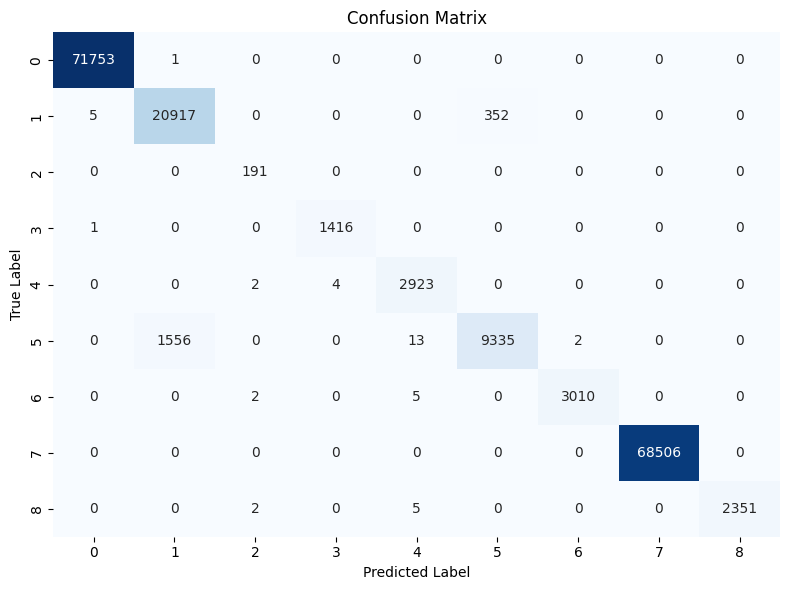

In [26]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Adjust layout to make room for the title
plt.tight_layout()

# Show plot
plt.show()

In [27]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9893063964201105


In [28]:
from sklearn.metrics import precision_score

precision = precision_score(y_test, y_pred_ensemble, average='weighted') # Use 'binary' for binary classification
print(f'Precision: {precision}')

Precision: 0.9895211560030611


In [29]:
from sklearn.metrics import recall_score

recall = recall_score(y_test, y_pred_ensemble, average='weighted') # Use 'binary' for binary classification
print(f'Recall: {recall}')

Recall: 0.9893063964201105


In [30]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred_ensemble, average='weighted') # Use 'binary' for binary classification
print(f'F1 Score: {f1}')

F1 Score: 0.9891386804280431


<ipython-input-31-76ca1e877004>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_values, y=metric_names, palette="viridis")


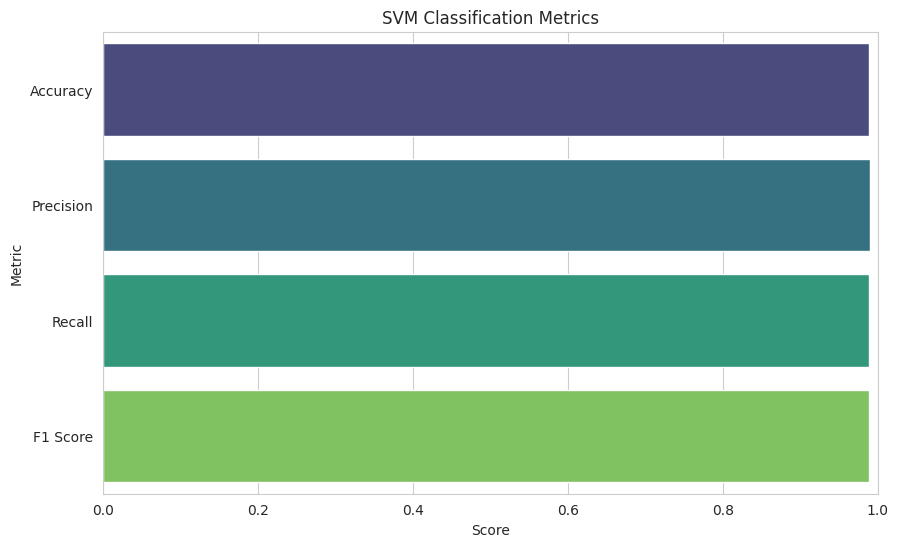

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming metrics are stored in these variables
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    # 'ROC-AUC': roc_auc  # Uncomment if ROC-AUC is applicable and calculated
}

# Convert dictionary to lists for plotting
metric_names = list(metrics.keys())
metric_values = [metrics[metric] for metric in metric_names]

# Create bar plot
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=metric_values, y=metric_names, palette="viridis")

plt.xlabel('Score')
plt.ylabel('Metric')
plt.title('SVM Classification Metrics')
plt.xlim(0, 1)  # Assuming the scores are between 0 and 1
plt.show()